# 缩写
- TLS  --  Transport Layer Security     传输层安全 
- URL  --  Uniform Resource Locator     统一资源定位器
- PLT  --  Page Load Time               页面加载时间
- RTT  --  Round-trip delay             来回通信延迟
- DNS  --  Domain Name System           域名系统
- TLD  --  Top-Level Domain servers     顶层域名服务器 
- TTL  --  Time to live                 存活时间
- DHT  --  Distributed Hash Table       分布式哈希表

# HTTP响应状态代码
- 200 OK
  - 请求成功，请求的对象在本消息的后面
- 301 已永久移动
  - 被请求的对象被移动，新的位置在本消息中稍后指定
- 304 Not Modified
  - don’t send object if cache has up-to-date cached version
- 400 错误请求
  - 请求讯息不被服务器理解
- 404 未找到
  - 所请求的文件在该服务器上没有找到
- 505 HTTP版本不支持

# How long does it take to download the page
`S0` = size of base file (bits)
`N`  = number of inline objects
`S`  = size of inline object (bits)
`C`  = link of capacity (bits/s)
`D`  = RTT

- HTTP/1.0 Non-persistent HTTP (without parallelism)
  - `2D + S0/C + N(2D + S/C)`

- HTTP/1.1 persistent HTTP (without parallelism or pipelining)
  - `2D + S0/C + N(D + S/C)`

- HTTP/1.1 persistent HTTP with pipelining
  - `3D + S0/C + NS/C`

# DNS Structure
- Root server 根名称服务器
  - 13 logical root name “servers”
- Top-level domain (TLD) server
  - .com, .edu, .gov

- Local server
  - clientside ISP
  - 不属于严格意义上的等级制度
  - 每个ISP（住宅ISP、公司、大学）都有一个
  - 有本地缓存的最近的名称-地址转换对（但可能是过时的）

- Authoritative server
  - domain name owner
  - 存储姓名与地址的映射关系
  - 由相应的管理机构维护

# DNS name resolution
- Iterated query
  - Host <-> Local
    - Local
      -  <-> Root
      -  <-> TLD 
      -  <-> Authoritative 
   
   - 被联系的服务器回复知情服务器的名称
   - 我不知道这个名字，但请问这个服务器

- Recursive query
  - Host <-> Local <-> Root <-> TLD <-> Authoritative
  
  - 将名称解析的负担放在联系的名称服务器上
  - 层次结构上层的沉重负担

# Caching, Updating DNS Records
- 一旦（任何）名称服务器学会了映射，它就会对映射进行缓存
- 缓存条目在一定时间（TTL）后超时（消失）。
- TLD服务器通常缓存在本地名称服务器中
- 因此，根名称服务器不经常被访问
- 缓存的条目可能是过时的（尽力而为的名称到地址转换！）
- 如果名称主机改变了IP地址，可能在整个互联网上都不知道，直到所有的TTLs过期
- 负面缓存
  - 记住不能用的东西
  - 如：拼写错误，如www.cnn.comm 和 www.cnnn.com

# DNS records
- distributed database storing resource records (RR)
- RR format: (name, value, type, ttl)
- type
  - A
    - name is hostname
    - value is IP address
  - NS
    - name is domain (e.g., foo.com)
    - value is hostname of authoritative name server for this domain
  - CNAME
    - name is alias name for some “canonical” (the real) name
    - www.ibm.com is really servereast.backup2.ibm.com
    - value is canonical name
  - MX
    - value is name of mailserver associated with name

# 在DNS中插入记录：
- 例如：新的创业公司 "Network Utopia"
- 在DNS注册商处注册名称networkuptopia.com
- 提供名称，权威名称服务器的IP地址（主要和次要的）
- 注册商将`NS、A` RR插入到.com TLD服务器。
  - `(networkutopia.com, dns1.networkutopia.com, NS)`
  - `(dns1.networkutopia.com, 212.212.212.1, A)`
- 在本地创建权威性服务器，IP地址为`212.212.212.1`
- 包含`A`类型的记录，`www.networkuptopia.com`
- 包含`MX`类型的记录, `networkutopia.com`

# 更新DNS记录
- 记住，旧的记录可能会被缓存在其他DNS服务器中（最长为TTL）
- 一般准则
  - 记录当前记录的TTL值
  - 降低记录的TTL值到一个低值（如30秒）
  - 等待前一个TTL的长度
  - 更新记录
  - 等待一段时间（例如，1小时）
  - 把TTL改回你以前的时间

# DNS Reliability

- DNS服务器被复制（主要/次要）
  - 如果至少有一个副本启动，则名称服务可用
  - 查询可以在副本之间进行负载平衡
- 通常，UDP用于查询
  - 需要可靠性：必须在UDP的基础上实现这一点
  - 规范也支持TCP，但不一定能实现
- DNS使用53号端口
- 在超时时尝试其他服务器
  - 重试同一服务器时的指数退避法 (Exponential backoff)
- 所有查询的标识符相同
  - 不关心哪个服务器响应

# WWW与非WWW域名的对比
- 例如，`www.metalhead.com` 或 `metalhead.com`
- 非WWW域名被称为顶级域名或裸域名(metalhead.com)
- 技术上来说，任何一个都可以作为主域名（对于搜索引擎），而另一个则被重定向到主域名（HTTP 301）
- 使用www有两个主要优势
  - DNS要求顶级域名总是指向A类型，并且CNAME记录不能与其他RR类型共存
  - 使用www域名，卸载到CDN很容易。
    - `www.metalhead.com CNAME somecdn.com`
    - `metalhead.com A 156.23.34.252`
    - 注意：有些CDN供应商对上述情况有变通办法
  - 顶点域名的Cookies会自动下传到子域名 `(metalhead.com to static.metalhead.com and mail.metalhead.com)`
    - 不必要的cookies会损害性能
    - 此外，还有安全问题

# Peer-to-peer (P2P)
- 没有永远在线的服务器
- 任意的终端系统直接交流
- Peer是间歇性连接，并改变IP地址
- Torrent files
  - file divided into 256Kb chunks
  - 包含该文件的跟踪者的地址
  - 包含一个文件块的列表和它们的加密哈希值
- 发送分块：针锋相对 (tit-for-tat)
  - 更高的上传率：找到更好的贸易伙伴，更快获得文件
  - BitTorrent uses tit-for-tat in each round to Determine to which peers to upload chunks
  - Alice向目前以最高速率向她发送分块的四个对等体发送分块
     - 其他对等体被Alice扼杀（不接收来自她的分块）。
     - 每10秒重新评估前4名
  - 每30秒：随机选择另一个对等体，开始发送数据块
    - "乐观地解除 "这个对等体的锁定
    - 新选择的对等体可以加入前4名

- DHT：一个分布式的P2P数据库
  - 数据库有`(key, value)` pairs
    - key: TFN号码；value：人名
    - key: 文件名；value: peer的IP地址（BitTorrent Tracker）
  - 将(key, value)对分布在许多peers上
  - 一个对等体用密钥`queries` DHT
    - DHT返回与键匹配的值
  - peer也可以`insert`（键，值）对
  - 基本想法。
    - 将每个键转换为一个整数
    - 给每个对等体分配整数值
    - 把（键，值）对放在 closest 键的对等体中
    - Consistent Hashing
      - 在[0,2^n-1]范围内为每个对等体分配整数标识符，用于某种n位散列函数
        - 例如，节点ID是其IP地址的哈希值
      - 要求每个密钥都是同一范围内的整数
      - 为了得到整数密钥，对原始密钥进行散列
    - 例如，n=4; Ids in the range [0-15], peers: 1,3,4,5,8,10,12,14;
      - key = 13, then successor peer = 14
      - key = 15, then successor peer = 1

# Circular DHT
- 每个对等体只知道直接的继任者和前任的情况
- "overlay network"
- 查询通常以顺时针方向传播
- 每个对等体保持2个邻居
- `Worst case: N messages, Average: N/2 messages`
- 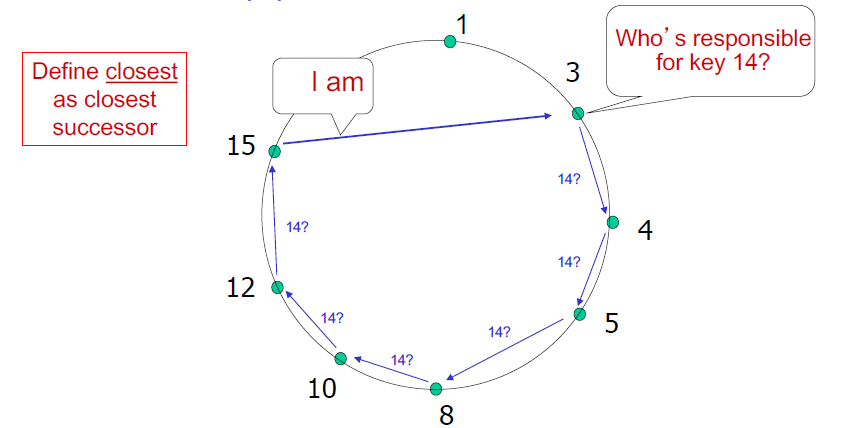

# Circular DHT with shortcuts
- 每个对等体跟踪前任、后任、捷径的IP地址。
- `O(log N) neighbours, O(log N) messages in query`
- 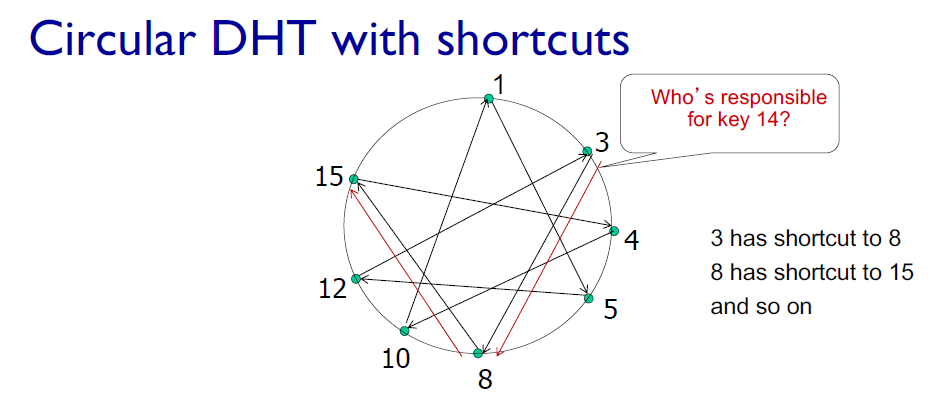
- 处理对等人的流失 peer churn
  - 对等体可能来来去去（流失）。
  - 每个对等体知道它的两个继承者地址
  - 每个对等体定期ping其两个继任者，以检查有效性。
  - 如果直接继承人离开，选择下一个继承人作为新的直接继承人

# Multimedia: video
- CBR：constant bit rate（恒定比特率）：
  - 编码率固定
- VBR：variable bit rate（可变比特率）：
  - 编码率随着空间、时间编码量的变化而变化
- Streaming video = encoding + DASH + playout buffering

# DASH -- Dynamic, Adaptive Streaming over HTTP
- 服务器:
  - 将视频文件分成多个块状物
  - 每块存储，以不同速率编码
  - manifest file 清单文件：为不同的块提供URL。
- 客户端:
  - 定期测量服务器到客户端的带宽
  - 咨询清单，一次请求一个大块
  - 在当前带宽下选择可持续的最大编码率
  - 可以在不同的时间点选择不同的编码率(取决于当时的可用带宽)

# Content distribution networks (CDNs)
- 在多个地理分布的站点存储/提供多个视频副本
- 订阅者从CDN请求内容 
  - 被引导到附近的副本，检索内容 
  - 如果网络路径拥堵，可以选择不同的副本
- OTT: “over the top”
  - OTT挑战：应对拥挤的互联网
  - 从哪个CDN节点检索内容？
  - 拥堵情况下的观众行为？
  - 在哪个CDN节点放置什么内容？